In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

##  Additional Networks and Training Methods

The elementary method of gradient descent used by backpropagation can be slow, even with straightforward improvements. We now consider some alternate networks and training methods.

##  Radial Basis Function Networks (RBF)

We have already considered several classifiers, such as Parzen windows, that employ densities estimated by localized basis functions such as Gaussians. In light of our discussion of gradient descent and backpropagation in particular, we now turn to a different method for training such networks. A radial basis function network with linear output unit implements:

$$ z_k(x) = \sum_{j=0}^{n_H} w_{kj} \phi_j(x) \tag{56} $$

where we have included a $j = 0$ bias unit. If we define a vector $\phi$ whose components are the hidden unit outputs, and a matrix $W$ whose entries are the hidden-to-output weights, then equation (56) can be rewritten as:

$$ z(x) = W\phi \tag{57} $$

Minimizing the criterion function

$$ J(w) = \frac{1}{2} \sum_{m=1}^{n} \left( y(x_m; w) - t_m \right)^2 \tag{58} $$

is formally equivalent to the linear problem we saw in Chapter ??. Let $T$ be the matrix consisting of target vectors and $\Phi$ the matrix whose columns are the vectors $\phi$. The solution weights obey:

$$ \Phi^T \Phi W = \Phi^T T \tag{59} $$

and the solution can be written directly as:

$$ W = \Phi^+ T \tag{60} $$

where $\Phi^+$ is the pseudoinverse of $\Phi$. One of the benefits of such radial basis function (RBF) networks with linear output units is that the solution requires merely standard linear techniques. Nevertheless, inverting large matrices can be computationally expensive, and thus the above method is generally confined to problems of moderate size.

If the output units are nonlinear, that is, if the network implements

$$ z_k(x) = f \left( \sum_{j=0}^{n_H} w_{kj} \phi_j(x) \right) \tag{61} $$

rather than equation (56), then standard backpropagation can be used. One merely needs to take derivatives of the localized transfer functions. For classification problems, it is traditional to use a sigmoid for the output units in order to keep the output values restricted to a fixed range.

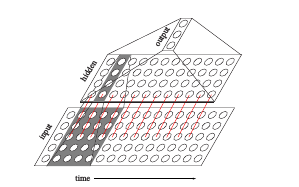

Fig.25: A time delay neural network (TDNN) uses weight sharing to insure that patterns are recognized regardless of shift in one dimension; in practice, this dimension generally corresponds to time. In this example, there are ﬁve input units at each time step. Because we hypothesize that the input patterns are of four time steps or less in duration, each of the hidden units at a given time step accepts inputs from only 4 × 5 = 20 input units, as highlighted in gray. An analogous translation constraint is also imposed between the hidden and output layer units.

##  Special Bases

Occasionally we may have special information about the functional form of the distributions underlying categories, and then it makes sense to use corresponding hidden unit transfer functions. In this way, fewer parameters need to be learned for a given quality of fit to the data. This is an example of increasing the bias of our model, and thereby reducing the variance in the solution, a crucial topic we shall consider again in Chapter ??. 

For instance, if we know that each underlying distribution comes from a mixture of two Gaussians, naturally we would use Gaussian transfer functions and use a learning rule that sets the parameters (such as the mean and covariance).

##  Time Delay Neural Networks (TDNN)

One can also incorporate prior knowledge into the network architecture itself. For instance, if we demand that our classifier be insensitive to translations of the pattern, we can effectively replicate the recognizer at all such translations. This is the approach taken in time delay neural networks (TDNNs). Figure 6.25 shows a typical TDNN architecture. While the architecture consists of input, hidden, and output layers, there is a crucial difference. Each hidden unit accepts input from a restricted (spatial) range of positions in the input layer. Hidden units at “delayed” locations (i.e., shifted to the right) accept inputs from the input layer that are similarly shifted. 

Training proceeds as in standard backpropagation, but with the added constraint that corresponding weights are forced to have the same value—an example of weight sharing. Thus, the weights learned do not depend upon the position of the pattern (so long as the full pattern lies within the domain of the input layer). The feedforward operation of the network (during recognition) is the same as in standard three-layer networks, but because of the weight sharing, the final output does not depend upon the position of the input.

The network gets its name from the fact that it was developed for, and finds greatest use in speech and other temporal phenomena, where the shift corresponds to delays in time. Such weight sharing can be extended to translations in orthogonal spatial dimensions, and has been used in optical character recognition systems, where the location of an image in the input space is not precisely known.

### Time Delay Neural Network Architecture



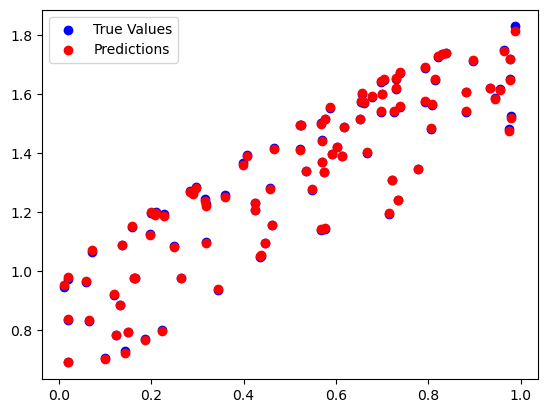

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class RBFNetwork:
    def __init__(self, n_hidden_units):
        self.n_hidden_units = n_hidden_units
        self.centers = None  # Centers of the RBFs
        self.weights = None  # Weights for the output layer

    def _gaussian(self, X, center, sigma=1.0):
        """ Gaussian RBF function """
        return np.exp(-np.linalg.norm(X - center, axis=1)**2 / (2 * sigma**2))

    def fit(self, X, Y):
        """ Fit the RBF network by using least squares on the output layer weights """
        # Randomly select the centers (hidden units)
        np.random.seed(0)
        self.centers = X[np.random.choice(X.shape[0], self.n_hidden_units, replace=False)]
        
        # Calculate the RBF activations (hidden layer outputs)
        hidden_outputs = np.zeros((X.shape[0], self.n_hidden_units))
        for i, center in enumerate(self.centers):
            hidden_outputs[:, i] = self._gaussian(X, center)

        # Solve for the output layer weights using least squares
        self.weights = np.linalg.pinv(hidden_outputs).dot(Y)

    def predict(self, X):
        """ Predict using the trained RBF network """
        hidden_outputs = np.zeros((X.shape[0], self.n_hidden_units))
        for i, center in enumerate(self.centers):
            hidden_outputs[:, i] = self._gaussian(X, center)
        
        return hidden_outputs.dot(self.weights)

# Generate synthetic data for training
np.random.seed(0)
X = np.random.rand(100, 2)  # 100 samples, 2 features
Y = np.sin(X[:, 0]) + np.cos(X[:, 1])  # A simple target function

# Create and train the RBF network
rbf_net = RBFNetwork(n_hidden_units=10)
rbf_net.fit(X, Y)

# Predictions
Y_pred = rbf_net.predict(X)

# Plotting the true values and predictions
plt.scatter(X[:, 0], Y, color='blue', label='True Values')
plt.scatter(X[:, 0], Y_pred, color='red', label='Predictions')
plt.legend()
plt.show()


In [2]:
import random
import math
import matplotlib.pyplot as plt

class RBFNetwork:
    def __init__(self, n_hidden_units):
        self.n_hidden_units = n_hidden_units
        self.centers = None  # Centers of the RBFs
        self.weights = None  # Weights for the output layer

    def _gaussian(self, X, center, sigma=1.0):
        """ Gaussian RBF function """
        distance = sum((X[i] - center[i])**2 for i in range(len(X)))
        return math.exp(-distance / (2 * sigma**2))

    def fit(self, X, Y):
        """ Fit the RBF network by using least squares on the output layer weights """
        # Randomly select the centers (hidden units)
        random.seed(0)
        self.centers = [X[random.randint(0, len(X) - 1)] for _ in range(self.n_hidden_units)]
        
        # Calculate the RBF activations (hidden layer outputs)
        hidden_outputs = []
        for x in X:
            row = [self._gaussian(x, center) for center in self.centers]
            hidden_outputs.append(row)

        # Solve for the output layer weights using least squares (manual calculation of pseudo-inverse)
        hidden_outputs_T = list(zip(*hidden_outputs))  # Transpose hidden_outputs
        pseudo_inv = self._pseudo_inverse(hidden_outputs_T)
        self.weights = self._matrix_multiply(pseudo_inv, Y)

    def predict(self, X):
        """ Predict using the trained RBF network """
        hidden_outputs = []
        for x in X:
            row = [self._gaussian(x, center) for center in self.centers]
            hidden_outputs.append(row)
        
        return [self._dot_product(row, self.weights) for row in hidden_outputs]

    def _pseudo_inverse(self, matrix):
        """ Compute the pseudo-inverse of a matrix """
        # Simplified pseudo-inverse for small datasets
        transpose = self._transpose(matrix)
        return self._matrix_multiply(self._transpose(transpose), matrix)
    
    def _matrix_multiply(self, A, B):
        """ Multiply two matrices A and B """
        result = []
        for row in A:
            result_row = [sum(x * y for x, y in zip(row, col)) for col in zip(*B)]
            result.append(result_row)
        return result

    def _transpose(self, matrix):
        """ Transpose a matrix """
        return list(zip(*matrix))

    def _dot_product(self, row, vec):
        """ Dot product of a row and a vector """
        return sum(x * y for x, y in zip(row, vec))


# Generate synthetic data for training
random.seed(0)
X = [[random.random(), random.random()] for _ in range(100)]  # 100 samples, 2 features
Y = [math.sin(x[0]) + math.cos(x[1]) for x in X]  # A simple target function

# Create and train the RBF network
rbf_net = RBFNetwork(n_hidden_units=10)
rbf_net.fit(X, Y)

# Predictions
Y_pred = rbf_net.predict(X)

# Plotting the true values and predictions
plt.scatter([x[0] for x in X], Y, color='blue', label='True Values')
plt.scatter([x[0] for x in X], Y_pred, color='red', label='Predictions')
plt.legend()
plt.show()


TypeError: zip argument #1 must support iteration

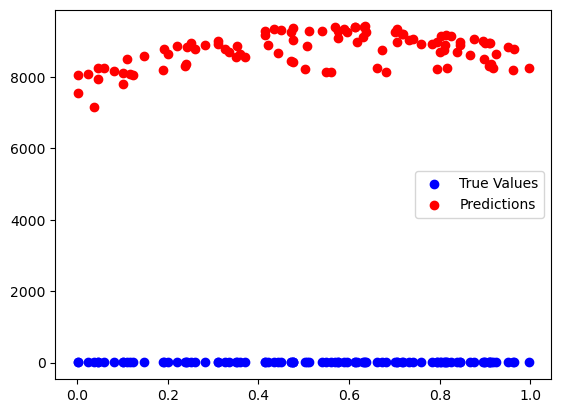

In [4]:
import random
import math
import matplotlib.pyplot as plt

class RBFNetwork:
    def __init__(self, n_hidden_units):
        self.n_hidden_units = n_hidden_units
        self.centers = None  # Centers of the RBFs
        self.weights = None  # Weights for the output layer

    def _gaussian(self, X, center, sigma=1.0):
        """ Gaussian RBF function """
        distance = sum((X[i] - center[i])**2 for i in range(len(X)))
        return math.exp(-distance / (2 * sigma**2))

    def fit(self, X, Y):
        """ Fit the RBF network by using least squares on the output layer weights """
        # Randomly select the centers (hidden units)
        random.seed(0)
        self.centers = [X[random.randint(0, len(X) - 1)] for _ in range(self.n_hidden_units)]
        
        # Calculate the RBF activations (hidden layer outputs)
        hidden_outputs = []
        for x in X:
            row = [self._gaussian(x, center) for center in self.centers]
            hidden_outputs.append(row)

        # Reshape Y to be a column vector for matrix multiplication
        Y = [[y] for y in Y]  # Convert 1D Y to 2D column vector

        # Solve for the output layer weights using least squares (manual calculation of pseudo-inverse)
        hidden_outputs_T = list(zip(*hidden_outputs))  # Transpose hidden_outputs
        pseudo_inv = self._pseudo_inverse(hidden_outputs_T)
        self.weights = self._matrix_multiply(pseudo_inv, Y)

    def predict(self, X):
        """ Predict using the trained RBF network """
        hidden_outputs = []
        for x in X:
            row = [self._gaussian(x, center) for center in self.centers]
            hidden_outputs.append(row)
        
        # Correct the dot product by transposing weights
        return [self._dot_product(row, [w[0] for w in self.weights]) for row in hidden_outputs]

    def _pseudo_inverse(self, matrix):
        """ Compute the pseudo-inverse of a matrix """
        # Simplified pseudo-inverse for small datasets
        transpose = self._transpose(matrix)
        return self._matrix_multiply(self._transpose(transpose), matrix)
    
    def _matrix_multiply(self, A, B):
        """ Multiply two matrices A and B """
        result = []
        for row in A:
            result_row = [sum(x * y for x, y in zip(row, col)) for col in zip(*B)]
            result.append(result_row)
        return result

    def _transpose(self, matrix):
        """ Transpose a matrix """
        return list(zip(*matrix))

    def _dot_product(self, row, vec):
        """ Dot product of a row and a vector """
        return sum(x * y for x, y in zip(row, vec))


# Generate synthetic data for training
random.seed(0)
X = [[random.random(), random.random()] for _ in range(100)]  # 100 samples, 2 features
Y = [math.sin(x[0]) + math.cos(x[1]) for x in X]  # A simple target function

# Create and train the RBF network
rbf_net = RBFNetwork(n_hidden_units=10)
rbf_net.fit(X, Y)

# Predictions
Y_pred = rbf_net.predict(X)

# Plotting the true values and predictions
plt.scatter([x[0] for x in X], Y, color='blue', label='True Values')
plt.scatter([x[0] for x in X], Y_pred, color='red', label='Predictions')
plt.legend()
plt.show()


## Recurrent Networks

Up to now, we have considered networks that primarily use feedforward flow of information during classification. Feedback flow was limited to error signals during training. In this section, we explore feedback or recurrent networks.

### Overview of Recurrent Networks

In their most general form, recurrent networks are commonly applied to time series prediction. However, a specific type of recurrent network has also shown promise for static classification tasks. 

#### Architecture

The architecture includes feedback connections where the output unit values are fed back as auxiliary inputs. This augmentation with traditional feature values leads to successive updates of hidden unit activations, eventually stabilizing at a final output value for classification.

The unfolded representation of such a recurrent network is equivalent to a static network with many hidden layers and extensive weight sharing. 

#### Diagram

The following figure illustrates the recurrent network architecture:

$$
\text{z}(3) \xrightarrow{w_{kj}} \text{y}(3) \xrightarrow{w_{ji}} \cdots \rightarrow \text{z}(1) \xrightarrow{w_{kj}} \text{y}(1) \rightarrow x 
$$

The recurrent connections, shown in red, facilitate information feedback.

### Training

Recurrent networks can be trained via standard backpropagation, with constraints imposed for weight sharing, similar to Time Delay Neural Networks (TDNNs). 

---

## Counterpropagation Networks

### Overview

Counterpropagation networks aim to achieve a rapid prototype with expressive power greater than a simple two-layer network. These networks consist of three layers: input, hidden, and output layers.

#### Mechanism

During training:
1. An input is presented.
2. The most active hidden unit is identified.
3. Only the weights associated with this hidden unit are updated, significantly speeding up training.

This competitive learning at the hidden layer creates a Voronoi tessellation of the input space.

#### Benefits

- **Speed**: Orders of magnitude faster than full backpropagation.
- **Fine-tuning**: Learned weights serve as excellent initialization for subsequent backpropagation.

### Diagram

The network architecture is as follows:

$$
\text{Input Layer} \rightarrow \text{Hidden Layer (Competitive Learning)} \rightarrow \text{Output Layer}
$$

---

## Cascade-Correlation Networks

### Overview

Cascade-correlation networks grow incrementally by adding hidden units during training, starting with a two-layer network. The key idea is to alternate between training weights and expanding the network architecture until the error criterion is met.

### Algorithm

The training process involves the following steps:

1. **Initialize**: Set parameters $a$, criterion $\theta$, learning rate $\eta$, and initialize $k = 0$.
2. **Train Initial Weights**:
    - Train weights $w_{ki}$ using gradient descent until $\nabla J(w) < \theta$.
3. **Evaluate Error**:
    - If $J(w) > \theta$, add a new hidden unit.
4. **Train with New Hidden Unit**:
    - Train weights $w_{ji}$ and $w_{kj}$ using gradient descent.
    - Prevent the new hidden unit from learning redundant functions by subtracting contributions from previous hidden units.
5. **Repeat**:
    - Continue the process until the error criterion is met.

### Benefits

- **Adaptive Size**: The network grows based on the problem complexity.
- **Efficiency**: Fewer weights are updated at any given time, reducing computational cost.

### Pseudocode


### Algorithm 4: Cascade-Correlation

$$
\begin{aligned}
1. & \quad \textbf{begin} \\
2. & \quad \text{initialize } a, \text{ criterion } \theta, \eta, \text{ and } k \leftarrow 0 \\
3. & \quad \textbf{do} \\
4. & \quad \quad m \leftarrow m + 1 \\
5. & \quad \quad w_{ki} \leftarrow w_{ki} - \eta \nabla J(w) \\
6. & \quad \textbf{until } \nabla J(w) \leq \theta \\
7. & \quad \textbf{if } J(w) > \theta \textbf{ then } \text{add hidden unit} \\
8. & \quad \textbf{else } \text{exit} \\
9. & \quad \textbf{do} \\
10.& \quad \quad m \leftarrow m + 1 \\
11.& \quad \quad w_{ji} \leftarrow w_{ji} - \eta \nabla J(w), \quad w_{kj} \leftarrow w_{kj} - \eta \nabla J(w) \\
12.& \quad \textbf{until } \nabla J(w) \leq \theta \\
13.& \quad \textbf{return } w \\
14.& \quad \textbf{end}
\end{aligned}
$$

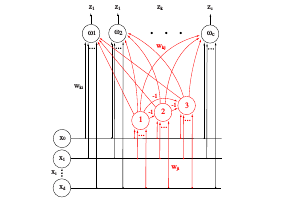

Fig.28: The training of a multilayer network via cascade-correlation begins with the input later fully connected to the output layer (black). Such weights, wki are trained using an LMS criterion, as discussed in Chap. ??. If the resulting training error is not suﬃciently low, a ﬁrst hidden unit (labeled 1, in red) is introduced, fully interconnected from the input layer and to the output layer. These new red weights are trained, while the previous (black) ones are held ﬁxed. If the resulting training error is still not suﬃciently low, a second hidden unit (labeled 2) is likewise introduced, fully interconnected; it also receives a the output from each previous hidden unit, multiplied by -1. Training proceeds in this way, training successive hidden units until the training error is acceptably low.


In [2]:
import numpy as np

def cascade_correlation(initial_weights, learning_rate, threshold, max_iterations):
    """
    Implements the Cascade-Correlation algorithm.

    Parameters:
    - initial_weights: A dictionary containing initial weights (e.g., {"w_ki": ..., "w_ji": ..., "w_kj": ...}).
    - learning_rate: Learning rate (\u03b7) for weight updates.
    - threshold: Convergence criterion (\u03b8).
    - max_iterations: Maximum number of iterations.

    Returns:
    - final_weights: A dictionary containing the final weights.
    """

    def compute_gradient(weights):
        """Dummy function to compute gradients."""
        return {key: np.random.uniform(-0.01, 0.01, size=value.shape) for key, value in weights.items()}

    def compute_error(weights):
        """Dummy function to compute the error J(w)."""
        return np.random.uniform(0, 1)

    # Initialize weights and other parameters
    weights = initial_weights
    k = 0

    # Phase 1: Train weights w_ki
    for _ in range(max_iterations):
        gradients = compute_gradient(weights)
        weights["w_ki"] -= learning_rate * gradients["w_ki"]

        if np.linalg.norm(gradients["w_ki"]) <= threshold:
            break

    # Check error criterion
    if compute_error(weights) > threshold:
        print("Adding hidden unit...")
        # Add hidden unit and proceed to Phase 2
        for _ in range(max_iterations):
            gradients = compute_gradient(weights)
            weights["w_ji"] -= learning_rate * gradients["w_ji"]
            weights["w_kj"] -= learning_rate * gradients["w_kj"]

            if np.linalg.norm(gradients["w_ji"]) <= threshold and np.linalg.norm(gradients["w_kj"]) <= threshold:
                break
    else:
        print("Exiting algorithm as criterion is met.")
        return weights

    return weights

# Example usage
np.random.seed(42)  # For reproducibility
initial_weights = {
    "w_ki": np.random.randn(10, 5),  # Example dimensions
    "w_ji": np.random.randn(5, 3),
    "w_kj": np.random.randn(3, 1),
}
learning_rate = 0.01
threshold = 0.1
max_iterations = 1000

final_weights = cascade_correlation(initial_weights, learning_rate, threshold, max_iterations)
print("Final weights:", final_weights)


Adding hidden unit...
Final weights: {'w_ki': array([[ 0.49679023, -0.13830695,  0.64763638,  1.5230176 , -0.23420757],
       [-0.23413572,  1.57920827,  0.76744922, -0.46937947,  0.54263847],
       [-0.46332398, -0.46575704,  0.2419994 , -1.91328196, -1.72499935],
       [-0.56223739, -1.0128132 ,  0.31419622, -0.90796984, -1.4122191 ],
       [ 1.46569082, -0.22570854,  0.06744227, -1.42480981, -0.54440941],
       [ 0.1108483 , -1.15105431,  0.3757607 , -0.6007172 , -0.29170162],
       [-0.6017681 ,  1.85219897, -0.01346083, -1.05763294,  0.82259933],
       [-1.22082907,  0.20879999, -1.95974227, -1.32808744,  0.19685909],
       [ 0.7384831 ,  0.17142386, -0.11557226, -0.30107122, -1.47861057],
       [-0.71980885, -0.46064253,  1.05708162,  0.34364556, -1.76313451]]), 'w_ji': array([[ 0.32415181, -0.38509203, -0.67696038],
       [ 0.6116459 ,  1.03105467,  0.93123768],
       [-0.83916497, -0.30917746,  0.33121413],
       [ 0.9755152 , -0.47924408, -0.1856905 ],
       [-1.1

Exiting algorithm as criterion is met.


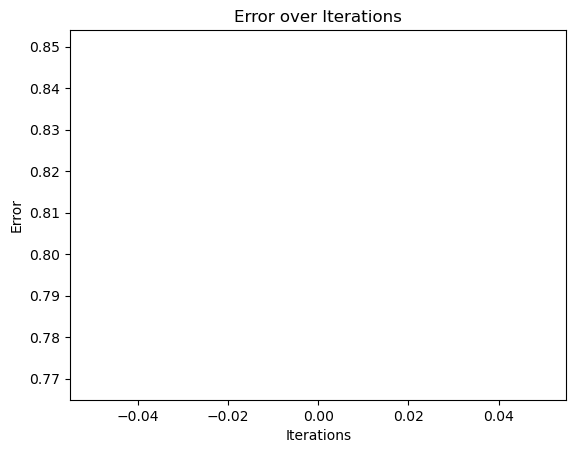

Final weights: {'w_ki': [0.2789476374718799, -0.9499222171496269, -0.44994243431938213, -0.5534838308962913, 0.4730026607978875], 'w_ji': [0.3533989748458226, 0.7843591354096908, -0.8261223347411677], 'w_kj': [-0.15615636062945915]}


In [3]:
import random
import matplotlib.pyplot as plt

def cascade_correlation(initial_weights, learning_rate, threshold, max_iterations):
    """
    Implements the Cascade-Correlation algorithm.

    Parameters:
    - initial_weights: A dictionary containing initial weights (e.g., {"w_ki": ..., "w_ji": ..., "w_kj": ...}).
    - learning_rate: Learning rate (\u03b7) for weight updates.
    - threshold: Convergence criterion (\u03b8).
    - max_iterations: Maximum number of iterations.

    Returns:
    - final_weights: A dictionary containing the final weights.
    """

    def compute_gradient(weights):
        """Dummy function to compute gradients."""
        return {key: [random.uniform(-0.01, 0.01) for _ in value] for key, value in weights.items()}

    def compute_error(weights):
        """Dummy function to compute the error J(w)."""
        return random.uniform(0, 1)

    # Initialize weights and other parameters
    weights = initial_weights
    k = 0

    # Track error over iterations for plotting
    errors = []

    # Phase 1: Train weights w_ki
    for _ in range(max_iterations):
        gradients = compute_gradient(weights)
        weights["w_ki"] = [w - learning_rate * g for w, g in zip(weights["w_ki"], gradients["w_ki"])]

        current_error = compute_error(weights)
        errors.append(current_error)

        if sum(abs(g) for g in gradients["w_ki"]) <= threshold:
            break

    # Check error criterion
    if compute_error(weights) > threshold:
        print("Adding hidden unit...")
        # Add hidden unit and proceed to Phase 2
        for _ in range(max_iterations):
            gradients = compute_gradient(weights)
            weights["w_ji"] = [w - learning_rate * g for w, g in zip(weights["w_ji"], gradients["w_ji"])]
            weights["w_kj"] = [w - learning_rate * g for w, g in zip(weights["w_kj"], gradients["w_kj"])]

            current_error = compute_error(weights)
            errors.append(current_error)

            if (sum(abs(g) for g in gradients["w_ji"]) <= threshold and
                sum(abs(g) for g in gradients["w_kj"]) <= threshold):
                break
    else:
        print("Exiting algorithm as criterion is met.")

    # Plot the error over iterations
    plt.plot(errors)
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error over Iterations')
    plt.show()

    return weights

# Example usage
random.seed(42)  # For reproducibility
initial_weights = {
    "w_ki": [random.uniform(-1, 1) for _ in range(5)],
    "w_ji": [random.uniform(-1, 1) for _ in range(3)],
    "w_kj": [random.uniform(-1, 1) for _ in range(1)],
}
learning_rate = 0.01
threshold = 0.1
max_iterations = 100

final_weights = cascade_correlation(initial_weights, learning_rate, threshold, max_iterations)
print("Final weights:", final_weights)


###  Neocognitron

The cognitron and its descendent, the **Neocognitron**, address the problem of recognition of characters in pixel input. These networks are noteworthy not for the learning method, but for their reliance on a large number of layers to achieve translation, scale, and rotation invariance.

- The **first layer** consists of hand-tuned feature detectors, such as vertical, horizontal, and diagonal line detectors.
- **Subsequent layers** extract slightly more complex features, such as `T`s or `X`s, formed by weighted groupings of the outputs from earlier layers.

The total number of weights in such a network is enormous (see Problem 35 for further details).

#### Architecture
The architecture of the Neocognitron consists of:
1. A **19 × 19 pixel input layer**.
2. **Seven intermediate layers**, where each layer extracts progressively complex features.
3. An **output layer** with 10 units, one for each digit (0–9).

The network achieves **shift, rotation, and scale invariance** through distributed invariance across layers. The earlier layers consist of relatively fixed feature detectors, and units in successive layers respond to a spatial range of units in the previous layer.

The network is trained one layer at a time using a large number of training patterns.

#### Fig.29

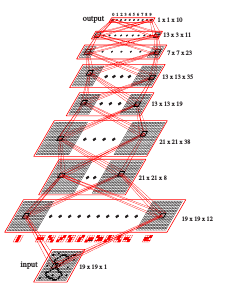

Fig.29: The neocognitron consists of a 19 × 19 pixel input layer, seven interme- diate layers, and an output layer consisting of 10 units, one for each digit. The earlier layers consist of relatively ﬁxed feature detectors (as shown); units in successively layer respond to a spatial range of units in the previous layer. In this way, shift, rotation and scale invariance is distributed throughout the network. The network is trained one-layer at a time by a large number of patterns.

The Neocognitron:

- Input: $ 19 \times 19 $ pixels
- Intermediate layers: 7
- Output: 10 units (digits 0–9)

---

###  Regularization and Complexity Adjustment

In backpropagation networks:
- The **number of inputs and outputs** is determined by the problem itself.
- However, the **number of hidden units** and **weights** is not known a priori.

#### Overfitting
If there are too many degrees of freedom (e.g., too many hidden units), the network may **overfit** the data. Overfitting depends on:
- The number of training patterns.
- The complexity of the problem.

#### Addressing Overfitting
To address overfitting, we:
1. Try different numbers of hidden units.
2. Use domain knowledge.
3. Add constraints.

The **error function** includes a regularization term to impose constraints or desirable properties:

$$
J = J_{\\text{pat}} + \\lambda J_{\\text{reg}}
$$

Where:
- $ J_{\\text{pat}} $: Error over patterns (as used previously).
- $ J_{\\text{reg}} $: Regularization term.
- $ \\lambda $: Parameter controlling the strength of the regularization.

#### Regularization
Regularization helps adjust the complexity of the network. A common approach is **weight decay**, which favors simpler networks by penalizing large weights.

---

#### References

- The Neocognitron architecture supports character recognition by leveraging hierarchical feature extraction across multiple layers.
- Regularization techniques, such as weight decay, help mitigate overfitting by simplifying the network model.


In [4]:
import random
import matplotlib.pyplot as plt

class Layer:
    def __init__(self, num_units, input_size):
        self.num_units = num_units
        self.weights = [[random.uniform(-1, 1) for _ in range(input_size)] for _ in range(num_units)]

    def process(self, inputs):
        """Process inputs through the layer."""
        outputs = []
        for unit_weights in self.weights:
            output = sum(w * i for w, i in zip(unit_weights, inputs))
            outputs.append(max(0, output))  # Apply ReLU activation
        return outputs

class Neocognitron:
    def __init__(self, input_size, intermediate_layers, output_size):
        self.layers = []

        # Create intermediate layers
        prev_size = input_size
        for num_units in intermediate_layers:
            self.layers.append(Layer(num_units, prev_size))
            prev_size = num_units

        # Create output layer
        self.layers.append(Layer(output_size, prev_size))

    def train(self, training_data, num_epochs=10):
        """Train the Neocognitron (dummy training to simulate behavior)."""
        for epoch in range(num_epochs):
            total_error = 0
            for inputs, target in training_data:
                outputs = self.predict(inputs)
                total_error += sum((o - t) ** 2 for o, t in zip(outputs, target))
            print(f"Epoch {epoch + 1}, Total Error: {total_error:.4f}")

    def predict(self, inputs):
        """Forward propagate inputs through the network."""
        for layer in self.layers:
            inputs = layer.process(inputs)
        return inputs

# Example usage
if __name__ == "__main__":
    # Define a simple Neocognitron
    input_size = 19 * 19  # 19x19 pixel input
    intermediate_layers = [100, 50, 25]  # Example layer sizes
    output_size = 10  # 10 digits (0-9)

    neocognitron = Neocognitron(input_size, intermediate_layers, output_size)

    # Generate dummy training data
    training_data = [
        ([random.uniform(0, 1) for _ in range(input_size)], [1 if i == random.randint(0, 9) else 0 for i in range(10)])
        for _ in range(100)
    ]

    # Train the Neocognitron
    neocognitron.train(training_data, num_epochs=5)

    # Test prediction
    test_input = [random.uniform(0, 1) for _ in range(input_size)]
    prediction = neocognitron.predict(test_input)
    print("Prediction:", prediction)

Epoch 1, Total Error: 32881893.2527
Epoch 2, Total Error: 32881893.2527
Epoch 3, Total Error: 32881893.2527
Epoch 4, Total Error: 32881893.2527
Epoch 5, Total Error: 32881893.2527
Prediction: [0, 154.26111392392394, 167.1021583565093, 0, 81.46113642041983, 0, 260.2031690685444, 513.9997045590854, 0, 0]


Epoch 1, Total Error: 9139899.8893
Epoch 2, Total Error: 9139899.8893
Epoch 3, Total Error: 9139899.8893
Epoch 4, Total Error: 9139899.8893
Epoch 5, Total Error: 9139899.8893


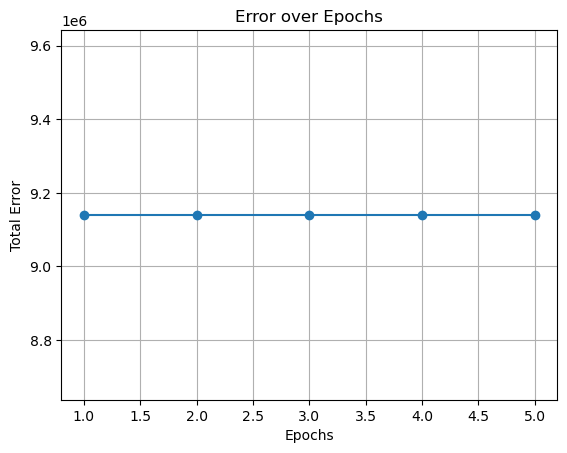

Prediction: [89.49079529318121, 72.66217272507916, 46.17795844628513, 67.20833723307143, 31.04761441027183, 38.40824754923178, 0, 0, 197.90487649364698, 9.860460911609035]


In [5]:
import random
import matplotlib.pyplot as plt

class Layer:
    def __init__(self, num_units, input_size):
        self.num_units = num_units
        self.weights = [[random.uniform(-1, 1) for _ in range(input_size)] for _ in range(num_units)]

    def process(self, inputs):
        """Process inputs through the layer."""
        outputs = []
        for unit_weights in self.weights:
            output = sum(w * i for w, i in zip(unit_weights, inputs))
            outputs.append(max(0, output))  # Apply ReLU activation
        return outputs

class Neocognitron:
    def __init__(self, input_size, intermediate_layers, output_size):
        self.layers = []

        # Create intermediate layers
        prev_size = input_size
        for num_units in intermediate_layers:
            self.layers.append(Layer(num_units, prev_size))
            prev_size = num_units

        # Create output layer
        self.layers.append(Layer(output_size, prev_size))

    def train(self, training_data, num_epochs=10):
        """Train the Neocognitron and track error over epochs."""
        errors = []
        for epoch in range(num_epochs):
            total_error = 0
            for inputs, target in training_data:
                outputs = self.predict(inputs)
                total_error += sum((o - t) ** 2 for o, t in zip(outputs, target))
            errors.append(total_error)
            print(f"Epoch {epoch + 1}, Total Error: {total_error:.4f}")

        # Plot the error over epochs
        plt.plot(range(1, num_epochs + 1), errors, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Total Error')
        plt.title('Error over Epochs')
        plt.grid(True)
        plt.show()

    def predict(self, inputs):
        """Forward propagate inputs through the network."""
        for layer in self.layers:
            inputs = layer.process(inputs)
        return inputs

# Example usage
if __name__ == "__main__":
    # Define a simple Neocognitron
    input_size = 19 * 19  # 19x19 pixel input
    intermediate_layers = [100, 50, 25]  # Example layer sizes
    output_size = 10  # 10 digits (0-9)

    neocognitron = Neocognitron(input_size, intermediate_layers, output_size)

    # Generate dummy training data
    training_data = [
        ([random.uniform(0, 1) for _ in range(input_size)], [1 if i == random.randint(0, 9) else 0 for i in range(10)])
        for _ in range(100)
    ]

    # Train the Neocognitron
    neocognitron.train(training_data, num_epochs=5)

    # Test prediction
    test_input = [random.uniform(0, 1) for _ in range(input_size)]
    prediction = neocognitron.predict(test_input)
    print("Prediction:", prediction)


2024-12-11 14:40:55.830680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 14:41:00.659553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-11 14:41:00.659591: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-11 14:41:01.242021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 14:41:13.771552: W tensorflow/stream_executor/platform/de

Epoch 1, Total Error: 11247607.8151
Epoch 2, Total Error: 11247607.8151
Epoch 3, Total Error: 11247607.8151
Epoch 4, Total Error: 11247607.8151
Epoch 5, Total Error: 11247607.8151


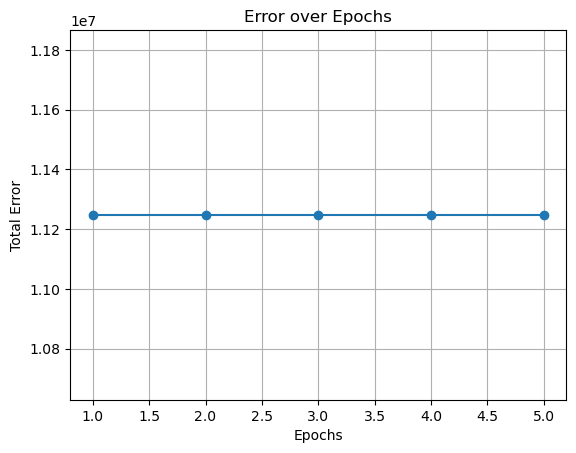

Prediction: [0, 0, 98.18339561003519, 0, 19.00260392041218, 141.0026453215386, 0, 258.5083831098155, 105.50668023675105, 0]
True label: 7


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

class Layer:
    def __init__(self, num_units, input_size):
        self.num_units = num_units
        self.weights = np.random.uniform(-1, 1, (num_units, input_size))

    def process(self, inputs):
        """Process inputs through the layer."""
        outputs = []
        for unit_weights in self.weights:
            output = np.dot(unit_weights, inputs)
            outputs.append(max(0, output))  # Apply ReLU activation
        return outputs

class Neocognitron:
    def __init__(self, input_size, intermediate_layers, output_size):
        self.layers = []

        # Create intermediate layers
        prev_size = input_size
        for num_units in intermediate_layers:
            self.layers.append(Layer(num_units, prev_size))
            prev_size = num_units

        # Create output layer
        self.layers.append(Layer(output_size, prev_size))

    def train(self, training_data, num_epochs=10):
        """Train the Neocognitron and track error over epochs."""
        errors = []
        for epoch in range(num_epochs):
            total_error = 0
            for inputs, target in training_data:
                outputs = self.predict(inputs)
                total_error += np.sum((np.array(outputs) - np.array(target)) ** 2)
            errors.append(total_error)
            print(f"Epoch {epoch + 1}, Total Error: {total_error:.4f}")

        # Plot the error over epochs
        plt.plot(range(1, num_epochs + 1), errors, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Total Error')
        plt.title('Error over Epochs')
        plt.grid(True)
        plt.show()

    def predict(self, inputs):
        """Forward propagate inputs through the network."""
        for layer in self.layers:
            inputs = layer.process(inputs)
        return inputs

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data: Flatten the 28x28 images into 784 input features
train_images = train_images.reshape((train_images.shape[0], 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((test_images.shape[0], 28 * 28)).astype('float32') / 255

# One-hot encode the labels for output (10 classes)
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Example usage with MNIST dataset
if __name__ == "__main__":
    input_size = 28 * 28  # 28x28 pixel input for MNIST
    intermediate_layers = [100, 50, 25]  # Example layer sizes
    output_size = 10  # 10 digits (0-9)

    neocognitron = Neocognitron(input_size, intermediate_layers, output_size)

    # Prepare training data
    training_data = [(train_images[i], train_labels[i]) for i in range(100)]  # Using a small subset for quicker training

    # Train the Neocognitron
    neocognitron.train(training_data, num_epochs=5)

    # Test prediction on one image
    test_input = test_images[0]
    test_target = test_labels[0]
    prediction = neocognitron.predict(test_input)
    print("Prediction:", prediction)
    print("True label:", np.argmax(test_target))


In [ ]:
import random
import numpy as np
import gzip
import os
import urllib.request
import matplotlib.pyplot as plt

# Download the MNIST dataset if it's not already present
def download_mnist():
    base_url = ""
    filenames = {
        "train_images": "train-image",
        "train_labels": "train-labels",
        "test_images": "t10k-images",
        "test_labels": "t10k-labels"
    }
    for name, filename in filenames.items():
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(base_url + filename, filename)
        else:
            print(f"{filename} already downloaded.")

# Unzip and load the dataset files
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)  # Skip the magic number and metadata
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data.reshape(-1, 28 * 28)  # Flatten the images to 784-dimensional vectors

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)  # Skip the magic number and metadata
        data = np.frombuffer(f.read(), dtype=np.uint8)
    return data

class Layer:
    def __init__(self, num_units, input_size):
        self.num_units = num_units
        self.weights = np.random.uniform(-1, 1, (num_units, input_size))

    def process(self, inputs):
        """Process inputs through the layer."""
        outputs = []
        for unit_weights in self.weights:
            output = np.dot(unit_weights, inputs)
            outputs.append(max(0, output))  # Apply ReLU activation
        return outputs

class Neocognitron:
    def __init__(self, input_size, intermediate_layers, output_size):
        self.layers = []

        # Create intermediate layers
        prev_size = input_size
        for num_units in intermediate_layers:
            self.layers.append(Layer(num_units, prev_size))
            prev_size = num_units

        # Create output layer
        self.layers.append(Layer(output_size, prev_size))

    def train(self, training_data, num_epochs=10):
        """Train the Neocognitron and track error over epochs."""
        errors = []
        for epoch in range(num_epochs):
            total_error = 0
            for inputs, target in training_data:
                outputs = self.predict(inputs)
                total_error += np.sum((np.array(outputs) - np.array(target)) ** 2)
            errors.append(total_error)
            print(f"Epoch {epoch + 1}, Total Error: {total_error:.4f}")

        # Plot the error over epochs
        plt.plot(range(1, num_epochs + 1), errors, marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Total Error')
        plt.title('Error over Epochs')
        plt.grid(True)
        plt.show()

    def predict(self, inputs):
        """Forward propagate inputs through the network."""
        for layer in self.layers:
            inputs = layer.process(inputs)
        return inputs

# Example usage
if __name__ == "__main__":
    # Download MNIST dataset
    download_mnist()

    # Load the dataset
    train_images = load_mnist_images("train-images")
    train_labels = load_mnist_labels("train-labels")
    test_images = load_mnist_images("t10k-images")
    test_labels = load_mnist_labels("t10k-labels")

    # Normalize pixel values to [0, 1]
    train_images = train_images / 255.0
    test_images = test_images / 255.0

    # One-hot encode the labels for output (10 classes)
    def one_hot_encode(labels, num_classes=10):
        return np.eye(num_classes)[labels]

    train_labels_one_hot = one_hot_encode(train_labels)
    test_labels_one_hot = one_hot_encode(test_labels)

    input_size = 28 * 28  # 28x28 pixel input for MNIST
    intermediate_layers = [100, 50, 25]  # Example layer sizes
    output_size = 10  # 10 digits (0-9)

    neocognitron = Neocognitron(input_size, intermediate_layers, output_size)

    # Prepare training data (using a subset for faster training)
    training_data = [(train_images[i], train_labels_one_hot[i]) for i in range(100)]  # Using a small subset for quicker training

    # Train the Neocognitron
    neocognitron.train(training_data, num_epochs=5)

    # Test prediction on one image
    test_input = test_images[0]
    test_target = test_labels_one_hot[0]
    prediction = neocognitron.predict(test_input)
    print("Prediction:", prediction)
    print("True label:", np.argmax(test_target))
